In [1]:
import acquire
import prepare
import explore
import model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
import scipy.stats as stats

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

import matplotlib as mpl

plt.rc('figure', figsize=(13, 10))
plt.rc('font', size=16)
plt.style.use('seaborn-darkgrid')

import warnings
warnings.filterwarnings('ignore')

# Github Repository Language Prediction: a Machine Learning Approach Using Natural Language Processing

## Project Goal

The goal of this project was to predict the programming language used in Github repositories based on the contents of the README file. The ability to classify repositories based on the README is useful for search engine optimization and potentially for data storage strategies. Features from the README texts were built leveraging natural language processing techniques such as bag of words and tf-idf scores. These features were inputted to numerous machine learning classification models to predict the programming language based on the README text.

## Data Acquisition

Data was acquired from 150 data science repositories from three different programming languages: Python, C++, and Java. The list of repositories acquired was based on performing a search for "machine learning" and specifying the programming language. Acquisition is accomplished using the acquire.py module and results in a dataset with 50 repositories for each language. The acquired data is also saved to a data.json cache to allow for faster subsequent loads.

In [2]:
# Acquire the data
df = acquire.get_repo_data()

Data consists of the repo name, language, and raw readme_contents.

In [3]:
# Take a quick look at df
df.head(2)

,repo,language,readme_contents
0,janishar/mit-deep-learning-book-pdf,Java,[![Download](https://img.shields.io/badge/down...
1,Angel-ML/angel,Java,![](assets/angel_logo.png)\n\n[![license](http...


## Data Preparation

The data was prepared by performing the following:
- Cleaning: converting text to lowercase, normalizing the text to remove inconsistencies in unicode character encoding, and encoding strings to ASCII. Also, any text not a through z, a number, a single quote, or whitespace was removed.
- Stemming: using the Porter method the stems of each word were extracted
- Lemmatizing: using the WordNetLemmatizer in nltk the root word was extracted
- Stopword removal: removing words with little or no significance to focus the exploration and modeling on words with lower frequency. Based on exploration extra words were added to the stopword removal process as these words did not add significant value to differentiating the repository's language.
- New features were made with the word counts and overall readme length, for the original, stemmed, and lemmatized versions.

In [4]:
# Words to include as a stopwords
extra_words = ['see', 'source', 'example', 'code', 'use', '1', "'", ';', '&#9']
# Call the prepare function from the script
prepared_data = prepare.prepare_df(df, column =  'readme_contents', extra_words = extra_words)

In [5]:
# Look at the prepare df
prepared_data.head(2)

,repo,language,readme_contents,clean,stemmed,lemmatized,original_length,stem_length,lem_length,original_word_count,stemmed_word_count,lemmatized_word_count
0,janishar/mit-deep-learning-book-pdf,Java,[![Download](https://img.shields.io/badge/down...,downloadhttpsimgshieldsiobadgedownloadbookmark...,downloadhttpsimgshieldsiobadgedownloadbookmark...,downloadhttpsimgshieldsiobadgedownloadbookmark...,2995,1971,2112,369,212,214
1,Angel-ML/angel,Java,![](assets/angel_logo.png)\n\n[![license](http...,assetsangellogopng licensehttpimgshieldsiobadg...,assetsangellogopng licensehttpimgshieldsiobadg...,assetsangellogopng licensehttpimgshieldsiobadg...,7394,5235,5508,511,349,350


The data was split into train, validate, and test sets for further exploration and modeling.

In [6]:
# Call split function
train, validate, test = prepare.train_validate_test_split(prepared_data, target = 'language')

## Exploration

We used our train split to explore the data. During exploration, we analyzed the data to answer the following questions:
- What are the most common words in the READMEs?
- Does the length of the README vary by programming language?

### Question: What are the most common words in the READMEs?
We can create a new dataframe to represent the word counts of our READMEs by using segmenting our data by category and then taking the frequency of the individual words. For the sake of our exploration this was done using our lemmatized words. The frequencies are then combined into a single dataframe, word_counts, where we can analyze the outcomes.

In [7]:
# Calling the word_counts() function from the explore module with our train df
word_counts = explore.word_counts(train)

In [8]:
# An example of seeing what words are the most frequent overall, changing the column for by='{column}' we could
# specify which language we want to check the top frequency of words for. 
word_counts.sort_values(by='all', ascending=False).head()

,all,java,python,c++
install,1123,21,1007,95
codea,894,0,894,0
detail,712,7,678,27
pip,705,11,661,33
open,704,17,664,23


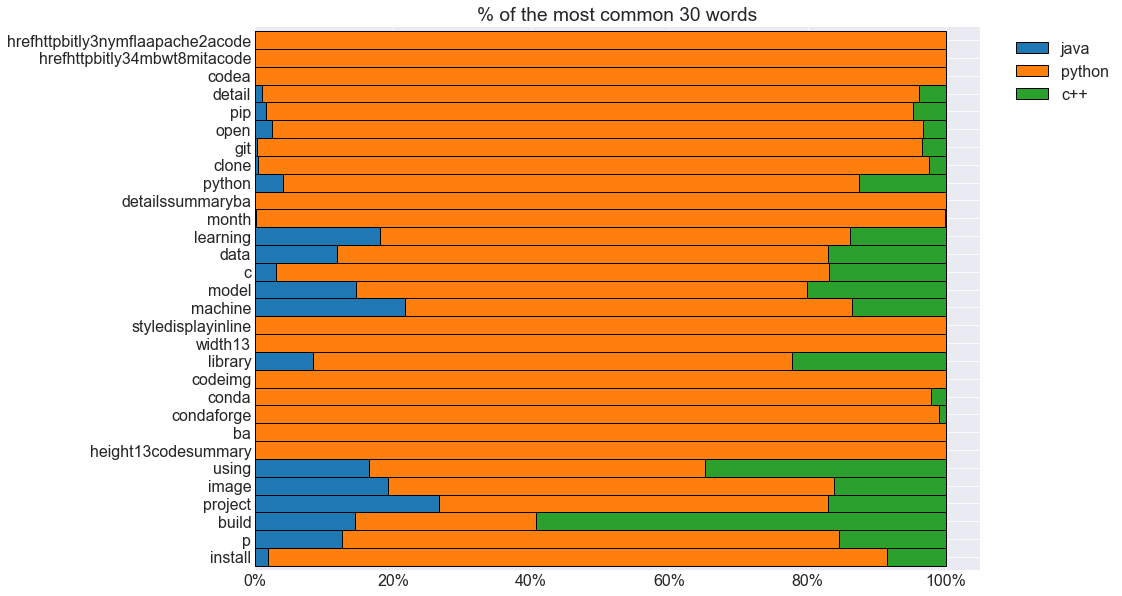

In [9]:
# Most common words sorted by each language
explore.common_words(word_counts)

**Takeaways**
- Python is the most commonly language followed by C++
- open, git, clone, conda, appear mostly in Python
- Words like : model, learning, machine, build are frequent words. They appear in all languages

### Question: Does the length of the README vary by programming language?

In [19]:
# Find the readme length by programming language
train.groupby('language').lem_length.mean().sort_values(ascending=False)

language
Python    23603.142857
C++        4869.500000
Java       4403.142857
Name: lem_length, dtype: float64

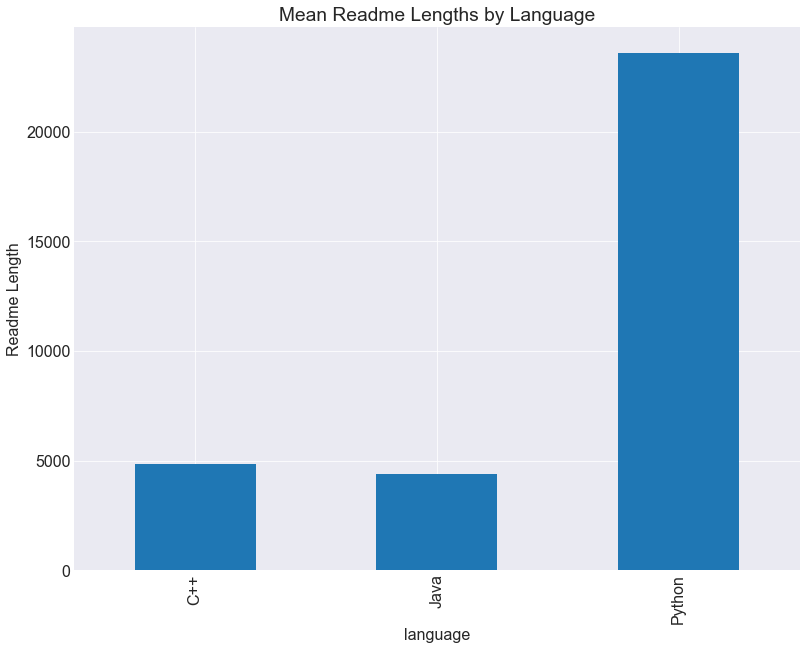

In [20]:
train.groupby('language').lem_length.mean().plot.bar()
plt.title('Mean Readme Lengths by Language')
plt.ylabel('Readme Length')
plt.show()

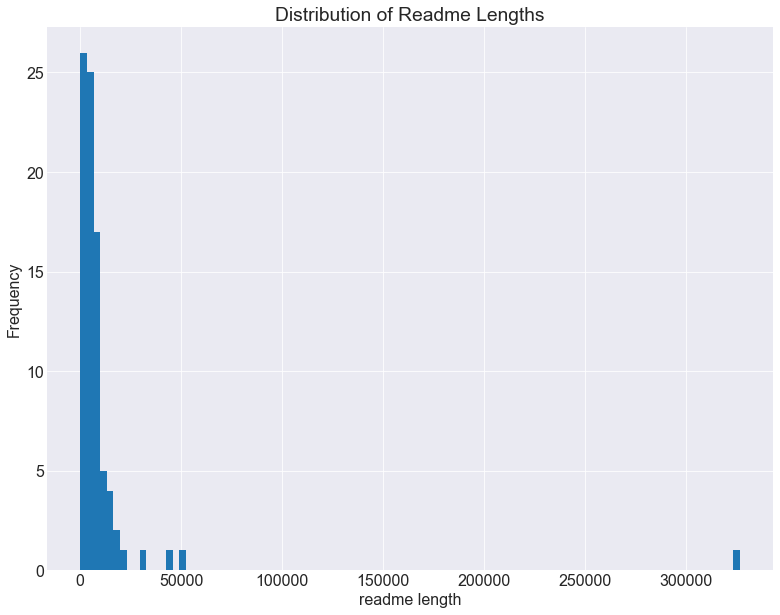

In [34]:
# visualize distribution of readme lengths
train.lem_length.plot.hist(bins=100)
plt.title('Distribution of Readme Lengths')
plt.xlabel('readme length')
plt.show()

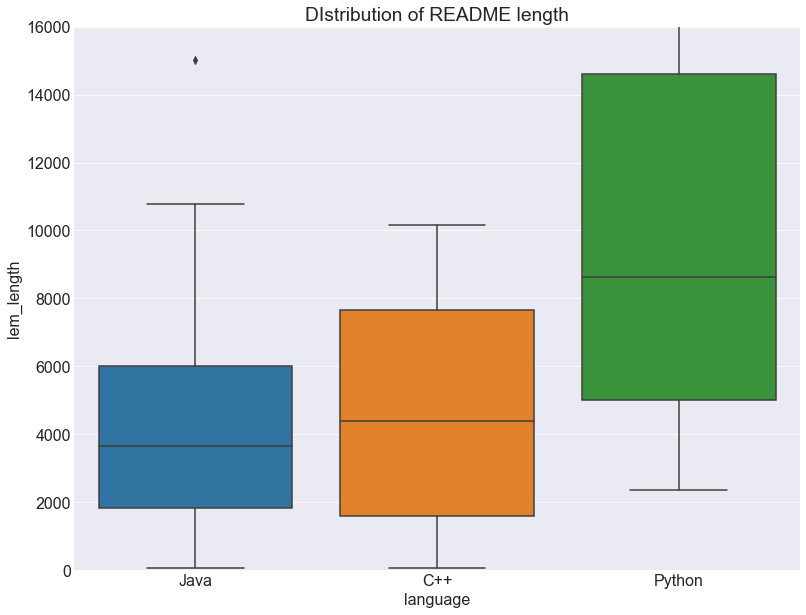

In [33]:
import seaborn as sns
sns.boxplot(x='language',y ='lem_length', data= train)
plt.title('DIstribution of README length')
plt.ylim(0, 16000)
None

**Takeaways**

- The readme length varies by programming language
- Python has the longest average readme length
- C++ and Java have average readme length below 5,000
- There are some outliers with readme lengths over 300,000
- Median Readme Lengths for all languages except Python is around 4,000

## Modeling

80 models were evaluated with the following options:
- Vectorizers: count vectorizer and tf-idf
- Models:
    - Multinomial Naive Bayes with default hyperparameters
    - Random Forest classifier with max depth of 1 and 2
    - Logistic Regression with C = {0.01, 0.1, 1.0}
    - Decision Tree classifier with max depth of 1 and 2

Top model based on highest accuracy on validate and least dropoff in performance from train to validate.

Models compared against a baseline of 33%. Because the data set is balanced among the three classes we have a 1/3 chance of choosing the correct language purely by chance.

In [10]:
target = 'language'
# Define list of vectorizers
vectorizers = [CountVectorizer, TfidfVectorizer]
# Define list of classification models
class_models = [MultinomialNB(), 
                RandomForestClassifier(random_state=123, max_depth = 1), 
                RandomForestClassifier(random_state=123, max_depth = 2), 
                LogisticRegression(C=0.01),
                LogisticRegression(C=0.1),
                LogisticRegression(C=1.0),
                DecisionTreeClassifier(max_depth=1),
               DecisionTreeClassifier(max_depth=2)]
# Establish range of ngrams to use - (1,2) means use both unigrams and bigrams
ngram_range_values = [(1,1),(1,2),(2,2),(1,3),(2,3)]
print_results_param = False

In [11]:
results = model.model_multiple(vectorizers, class_models, ngram_range_values, train, validate, target, print_results_param)

Model results sorted by highest accuracy on validate, and lowest dropoff in accuracy from train to validate.

In [12]:
results.head(3)

,model_parameters,train_accuracy,validate_accuracy,dropoff,feature_names,feature_importances,top_features
"(TfidfVectorizer, RandomForestClassifier, (1, 1))","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.904762,0.666667,0.238095,"[00, 000000true, 0001, 0003, 001, 0016666, 004...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[graph, java, experiment, text, built, matplot..."
"(TfidfVectorizer, RandomForestClassifier, (1, 1))","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.952381,0.666667,0.285714,"[00, 000000true, 0001, 0003, 001, 0016666, 004...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[license, clustering, text, built, java, matpl..."
"(CountVectorizer, DecisionTreeClassifier, (1, 1))","{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.690476,0.638889,0.051587,"[00, 000000true, 0001, 0003, 001, 0016666, 004...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[githubactionshttpsimgshieldsiogithubworkflows...


In [13]:
results.iloc[2].model_parameters['max_depth']

2

Highest validate accuracy is the Random Forest Classifier but it appears quite overfit with a 24% dropoff in accuracy from train to validate. The Decision Tree Classifer appears to be best using the count vectorizer with unigrams solely and a max depth of 2.

Testing top model on withheld test set

In [14]:
train_class_report, validate_class_report, feature_names, feature_importances= model.model_words(CountVectorizer, 
                  DecisionTreeClassifier(max_depth = 2),
                  ngrams_range_value=(1,1), 
                  train=train, 
                  validate = test, # note use of test 
                  target='language',
                  print_results=False)

In [15]:
pd.DataFrame(validate_class_report)

,C++,Java,Python,accuracy,macro avg,weighted avg
precision,0.533333,0.750000,0.571429,0.6,0.618254,0.618254
recall,0.800000,0.600000,0.400000,0.6,0.600000,0.600000
f1-score,0.640000,0.666667,0.470588,0.6,0.592418,0.592418
support,10.000000,10.000000,10.000000,0.6,30.000000,30.000000


Slight drop in accuracy but overall pretty good at 60%, beating the baseline by 27%!

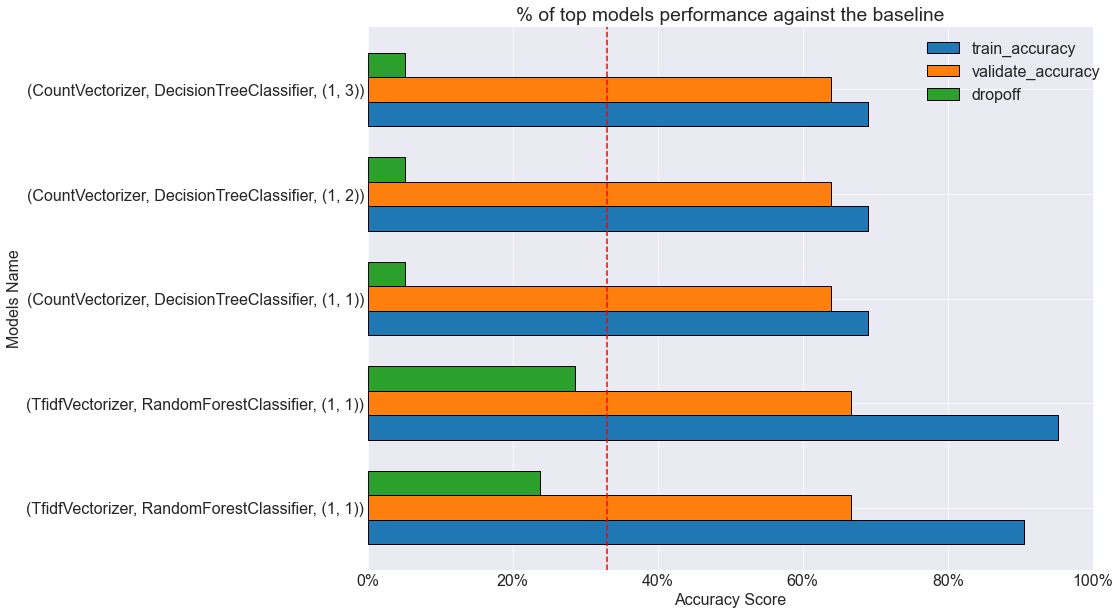

In [35]:
#For now manually set the baseline 
baseline = 0.33
#Plot the models to visualize the accuracy score
#Need to switch 'dropoff' with test score
results.sort_values(by=['validate_accuracy','dropoff'], ascending = [False, True]).head(5).plot.barh(stacked=False, width=0.7, ec='black')
plt.title(f'% of top models performance against the baseline')
plt.legend(bbox_to_anchor= (1.03,1))
plt.axvline(baseline, c='red', linestyle = '--')
plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter('{:.0%}'.format))
plt.ylabel('Models Name')
plt.xlabel('Accuracy Score')
plt.show()